# Data Exploration
In this notebook, we will explore the 4 files that we have been provided for the paper `Predicting food insecurity through news streams`. The paper uses IPC classfiications from `fews.net` for ground truth data. 

The **Integrated Food Security Phase Classification (IPC)** is a standardized system used to **assess and classify food insecurity levels**. It helps governments, humanitarian organizations, and policymakers make informed decisions about **food crises, early warning systems, and response planning**.

---

##### **🟢 IPC Classification Phases**
The IPC system classifies food insecurity into **five phases**, with each phase indicating the severity of the crisis:

| **IPC Phase** | **Classification**       | **Description** |
|--------------|------------------------|----------------|
| **1** 🟢 | **Minimal Food Insecurity** | Households can meet their food and non-food needs without external assistance. |
| **2** 🟡 | **Stressed** | Households have minimally adequate food consumption but are at risk of deterioration if shocks occur. |
| **3** 🟠 | **Crisis** | Households face food consumption gaps that lead to malnutrition or they must resort to severe coping strategies. |
| **4** 🔴 | **Emergency** | Households experience large food consumption gaps, leading to high acute malnutrition and excessive mortality. |
| **5** 🚨 | **Famine** | A catastrophic situation where starvation, death, and destitution are widespread. Requires immediate action. |

## Initialisation

In [106]:
%pip install pandas folium numpy tabulate pygments matplotlib seaborn --break-system-packages --quiet

Note: you may need to restart the kernel to use updated packages.


In [107]:
import pandas as pd
import numpy as np
import folium
from IPython.display import display, Image

In [108]:
df_famine_country = pd.read_csv("./data/famine-country-province-district-years-CS.csv")
df_matching_districts = pd.read_csv("./data/matching_districts.csv")
df_time_series = pd.read_csv("./data/time_series_with_causes_zscore_full.csv")
df_nodes = pd.read_csv("./data/fig_1_nodes.csv")

In [109]:
data = {
    "Seed keyphrase": [
        "famine", "food insecurity", "malnourished", "malnutrition",
        "food crisis", "starvation", "hunger crises", "shortage of food",
        "life-threatening hunger", "lack of food", "scarcity of food",
        "acute hunger", "dearth of food"
    ],
    "Number of articles containing frames": [
        25637, 25404, 12102, 10372, 10154, 8012, 6518, 5482,
        1895, 1266, 1058, 1043, 891
    ]
}

pd.DataFrame(data)


,Seed keyphrase,Number of articles containing frames
0,famine,25637
1,food insecurity,25404
2,malnourished,12102
3,malnutrition,10372
4,food crisis,10154
5,starvation,8012
6,hunger crises,6518
7,shortage of food,5482
8,life-threatening hunger,1895
9,lack of food,1266


In [110]:
def pretty_print_list(list_to_print):
    formatted_columns = "\n- " + "\n- ".join(list_to_print)  
    formatted_columns = sorted(list_to_print)
    print("\n- " + "\n- ".join(formatted_columns))

## Famine CSV

In this section, I will try and analyze the data from the `famine-country-province-district-years-CS.csv` file. 

In [111]:
df_famine_country.head(5)

,Unnamed: 0,country,district,year,month,CS,province
0,0,Ethiopia,Gabi,2009,7,1.0,Afar
1,1,Ethiopia,Gabi,2009,7,2.0,Afar
2,2,Ethiopia,Gabi,2009,7,3.0,Afar
3,3,Ethiopia,East Gojam,2009,7,1.0,Amhara
4,4,Ethiopia,East Gojam,2009,7,2.0,Amhara


I think the `Unnamed` column is the index of the data but it is the same as the index of the data frame. So I will drop it.

In [112]:
df_famine_country.drop(columns=["Unnamed: 0"], inplace=True) # this just seems like a redundant index column

df_columns = pd.DataFrame(df_famine_country.columns.values)

print("\n🗂️ LIST OF ALL COLUMN NAMES IN THE DATASET 🗂️")
print("These are the different attributes available in the dataset for analysis:\n")
df_columns


🗂️ LIST OF ALL COLUMN NAMES IN THE DATASET 🗂️
These are the different attributes available in the dataset for analysis:



,0
0,country
1,district
2,year
3,month
4,CS
5,province


In [113]:
print("No. of rows : ", df_famine_country.shape[0])
print("No. of columns : ", df_famine_country.shape[1])

No. of rows :  157091
No. of columns :  6


In [114]:
print("The data ranges from the year ", df_famine_country['year'].min(), " to ", df_famine_country['year'].max())

The data ranges from the year  2009  to  2017


The paper mentions that they have used data from `from July 2009 to July 2020`. This means that this file does not contain the data for the entire period.

In [115]:
unique_countries = df_famine_country['country'].unique()
formatted_countries = "\n- " + "\n- ".join(sorted(unique_countries))

print(f"\n🌍 The dataset covers the following {len(unique_countries)} countries:\n")
print(formatted_countries)



🌍 The dataset covers the following 39 countries:


- Abyei
- Afghanistan
- Angola
- Burkina Faso
- Burundi
- Cameroon
- Central African Republic
- Chad
- Congo
- Democratic Republic of the Congo
- Djibouti
- El Salvador
- Ethiopia
- Guatemala
- Guinea
- Haiti
- Honduras
- Iilemi triangle
- Kenya
- Liberia
- Madagascar
- Malawi
- Mali
- Mauritania
- Mozambique
- Niger
- Nigeria
- Rwanda
- Senegal
- Sierra Leone
- Somalia
- South Sudan
- Sudan
- Tajikistan
- Tanzania
- Uganda
- Yemen
- Zambia
- Zimbabwe


The paper says that they analyzed data from 21 countries, but this dataset contains 39 unique countries. 
>  The dataset covers 21 of the 37 countries in the FEWS NET dataset—Afghanistan, Burkina Faso, Chad, Democratic Republic of the Congo, Ethiopia, Guatemala, Haiti, Kenya, Malawi, Mali, Mauritania, Mozambique, Niger, Nigeria, Somalia, South Sudan, Sudan, Uganda, Republic of Yemen, Zambia, and Zimbabwe—over the period from July 2009 to July 2020.

In [116]:
countries_mentioned_in_paper_set = set(
    ["Afghanistan", "Burkina Faso", "Chad", "Democratic Republic of the Congo", "Ethiopia", 
    "Guatemala", "Haiti", "Kenya", "Malawi", "Mali", "Mauritania", "Mozambique", "Niger", 
    "Nigeria", "Somalia", "South Sudan", "Sudan", "Uganda", "Republic of Yemen", "Zambia", 
    "Zimbabwe"]
)

extra_countries = set(unique_countries) - countries_mentioned_in_paper_set
formatted_difference = "\n- " + "\n- ".join(sorted(list(extra_countries)))
print(f"Countries in dataset that are not mentioned in paper are {formatted_difference}")

missing_countries = countries_mentioned_in_paper_set - set(unique_countries)
formatted_missing = "\n- " + "\n- ".join(sorted(list(missing_countries)))
print(f"\n\nCountries mentioned in paper that are not in dataset are {formatted_missing}")


Countries in dataset that are not mentioned in paper are 
- Abyei
- Angola
- Burundi
- Cameroon
- Central African Republic
- Congo
- Djibouti
- El Salvador
- Guinea
- Honduras
- Iilemi triangle
- Liberia
- Madagascar
- Rwanda
- Senegal
- Sierra Leone
- Tajikistan
- Tanzania
- Yemen


Countries mentioned in paper that are not in dataset are 
- Republic of Yemen


Okay so upon manual inspection Yemen, Congo are mentioned in the paper but jsut under different names. 

In [117]:
count_rows_for_country = df_famine_country.groupby(['country']).size().reset_index(name='counts')
count_rows_for_country = count_rows_for_country.sort_values(by='counts', ascending=False)
count_rows_for_country

,country,counts
26,Nigeria,27640
1,Afghanistan,18269
13,Guatemala,17331
18,Kenya,13309
32,Sudan,9565
24,Mozambique,6374
12,Ethiopia,6095
31,South Sudan,5533
35,Uganda,5364
36,Yemen,5047


In [118]:
count_rows_for_country_per_district = df_famine_country.groupby(['country', 'district']).size().reset_index(name='counts')
count_rows_for_country_per_district

,country,district,counts
0,Abyei,Abyei,47
1,Afghanistan,Ab Band,40
2,Afghanistan,Ab Kamari,46
3,Afghanistan,Achin,45
4,Afghanistan,Adraskan,41
...,...,...,...
4126,Zimbabwe,Victoria Falls,64
4127,Zimbabwe,Zaka,50
4128,Zimbabwe,Zvimba,42
4129,Zimbabwe,Zvishavane Rural,53


This to me seems like it is a dataset of famines in different countries and their district by years and dates. I am still confised by what `CS` column means. It could be IPC classification but that has 5 categories only from 1 to 5 whereas this column has values like 88 and 0.

In [119]:
df_unique_cs = pd.DataFrame(df_famine_country["CS"].unique(), columns=["Unique CS Values"])
df_value_counts = df_famine_country["CS"].value_counts().reset_index()
df_value_counts.columns = ["CS Value", "Count"]
df_columns = pd.DataFrame(df_famine_country.columns, columns=["Dataset Columns"])

print("\n🌟 UNIQUE VALUES IN THE 'CS' COLUMN 🌟")
print("Below are all unique values found in the 'CS' column, which might represent different classifications or severity levels:\n")
df_unique_cs



🌟 UNIQUE VALUES IN THE 'CS' COLUMN 🌟
Below are all unique values found in the 'CS' column, which might represent different classifications or severity levels:



,Unique CS Values
0,1.0
1,2.0
2,3.0
3,99.0
4,4.0
5,88.0
6,5.0
7,0.0


Maybe it is a misclassification of the data? But upon inspecting more, there are about 4000 rows of data and it is not possible to be a misclassification. So I am still not sure what this column means.

In [120]:
print("\n📊 FREQUENCY DISTRIBUTION OF COLUMN 📊")
print("This table shows how frequently each unique value appears in the dataset, helping us understand the data distribution:\n")
df_value_counts


📊 FREQUENCY DISTRIBUTION OF COLUMN 📊
This table shows how frequently each unique value appears in the dataset, helping us understand the data distribution:



,CS Value,Count
0,1.0,89185
1,2.0,43355
2,3.0,17035
3,99.0,2660
4,4.0,2326
5,88.0,2138
6,0.0,333
7,5.0,59


### Final Verdict (Subject to change)

The `famine-country-province-district-years-CS.csv` dataset provides district-level food insecurity classifications across various countries, provinces, and time periods. It includes key attributes such as **country, province, district, year, month,** and a **CS (Crisis Severity) score**, which likely corresponds to the **Integrated Phase Classification (IPC) system** for food insecurity. The **CS values** range from **1 to 5**, representing different severity levels, with additional values like **88 and 99**, possibly indicating missing or uncertain data. This dataset serves as a **ground-truth reference** for analyzing food crises and evaluating predictive models that incorporate news-based and traditional risk indicators to anticipate food shortages.

## Matching districts CSV

In this section, we will analyze the data from the `matching-districts.csv` file.

In [121]:
df_matching_districts.head(5)

,missing,district,province,match
0,Port-Au-Prince,Port au Prince,Ituri,district
1,Teso,Teso South,El Progreso,district
2,Tanganyka,Tanga,Tanga,district
3,Tayeeglow,Tiyeglow,Bay,district
4,Kadoma,Kadoma Urban,Kano,district


This looks like a relatively small dataset as compared to the last one

In [122]:
print("No. of rows : ", df_matching_districts.shape[0])
print("No. of columns : ", df_matching_districts.shape[1])

No. of rows :  230
No. of columns :  4


Just by looking at the head of the data this seems to me like it is some sort of correction of either the district names or province names in the dataset depending on the `match` column. Like the missing and district columns have more less the same values for each row so I think this is a correction of the district names. By analyzing the DF more in Data Wrangler, my suspicions have been proved right. (I think)

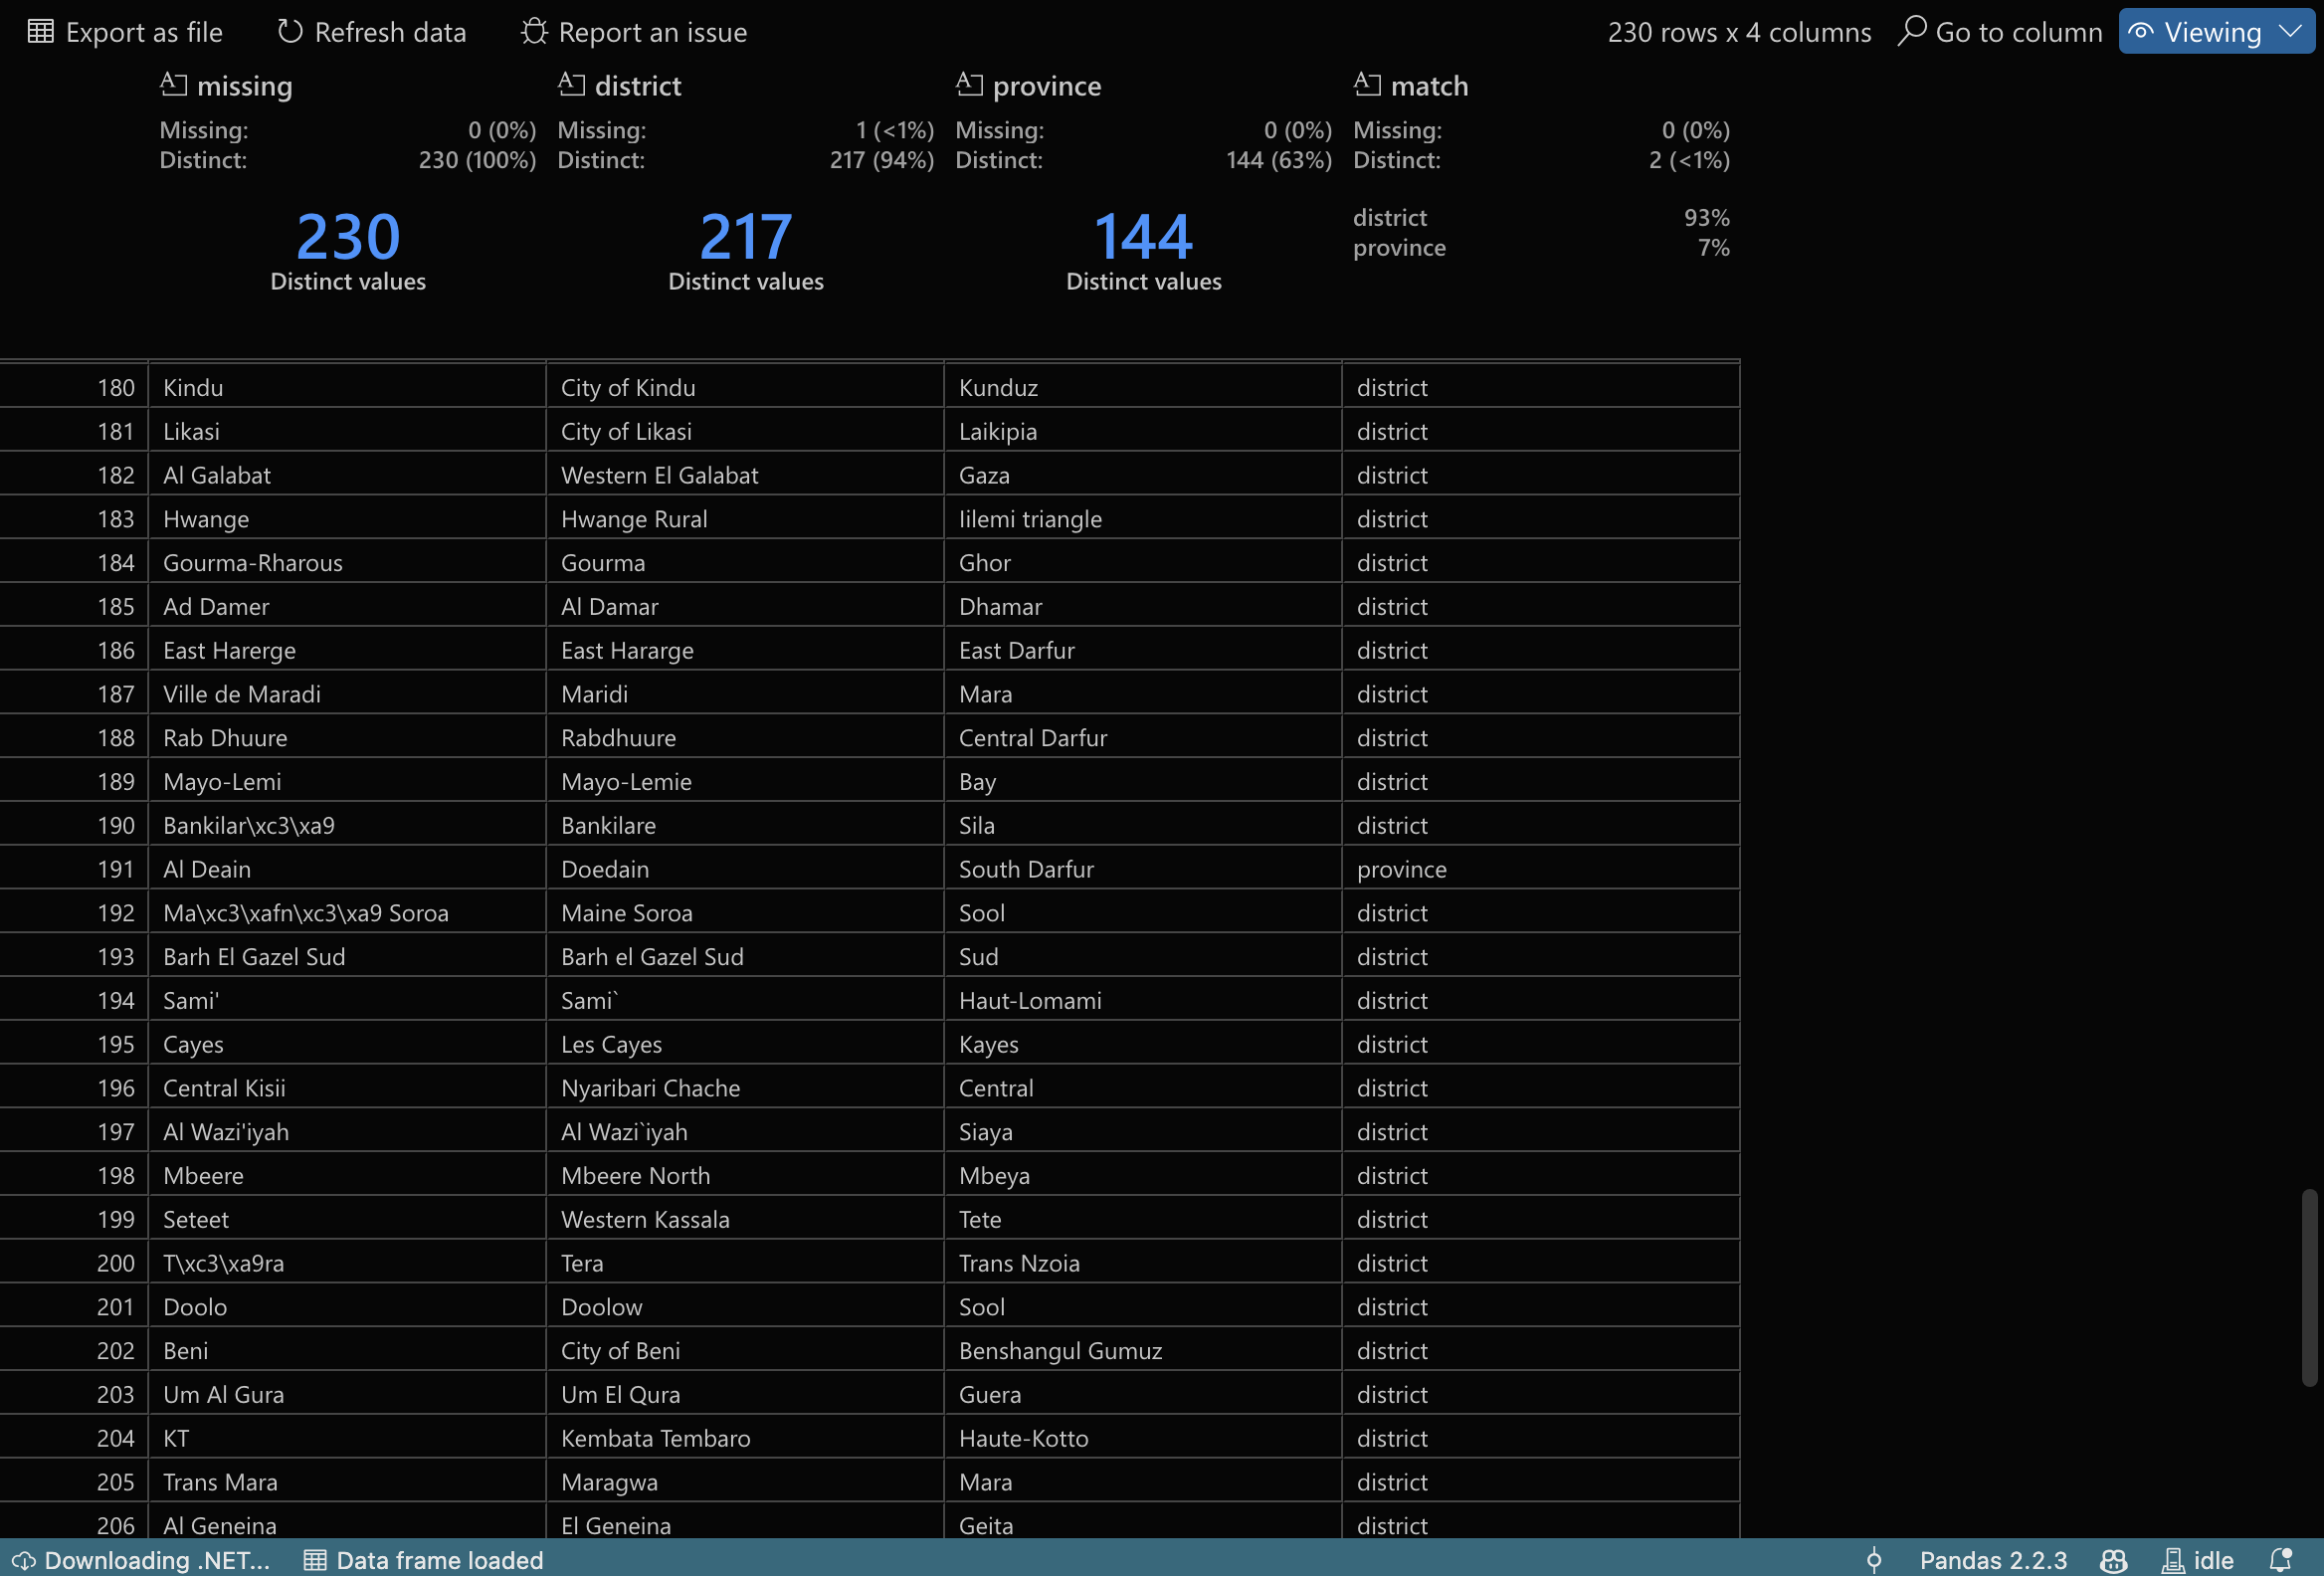

In [123]:
display(Image(filename="matching.png"))

### Final Verdict (Subject to change)
The **`matching_districts.csv`** file appears to contain **mapped corrections** or **standardized district names**, likely used to clean or align geographic data in the study.

- The dataset consists of **four columns**:
  1. **`missing`** → District names that were **incorrect, misspelled, or not found** in the main dataset.
  2. **`district`** → The **corrected district name** that aligns with official records or another dataset.
  3. **`province`** → The **province or administrative region** to which the district belongs.
  4. **`match`** → Specifies whether the correction refers to a **district** or potentially another administrative level.

This dataset is likely used for **data cleaning** to ensure that all districts match a **consistent naming standard**.

---

##### **🔍 Column-by-Column Breakdown**
| **Column Name** | **Likely Meaning** |
|---------------|----------------|
| **`missing`** | Contains district names that were **inconsistent, misspelled, or missing** from the main dataset. |
| **`district`** | The **corrected or standardized** district name that replaces the missing one. |
| **`province`** | The **province or region** associated with the corrected district. |
| **`match`** | Indicates whether the correction applies to a **district** or potentially another entity (e.g., province). |

---

This dataset helps by:
✅ **Fixing inconsistencies** in district names across different datasets.  
✅ **Ensuring accurate matching** of districts to food insecurity data.  
✅ **Improving model accuracy**, as mismatched districts could lead to errors in food crisis predictions.

> As can be seen above in the data wrangler Screenshot, the columns do have some weird encoding leading to many escaped characters.  
> I will have to clean this up (later).


## Time series CSV

In this section, we will analyze the data from the `time-series.csv` file.

In [124]:
df_time_series.head(5)

,Unnamed: 0,index,country,admin_code,admin_name,centx,centy,year_month,year,month,...,carbon_2,mayhem_0,mayhem_1,mayhem_2,dehydrated_0,dehydrated_1,dehydrated_2,mismanagement_0,mismanagement_1,mismanagement_2
0,0,30,Afghanistan,202,Kandahar,65.709343,31.043618,2009_07,2009,7,...,1.053000,0.667000,-0.171000,-0.833000,0.173667,0.168000,1.284667,-0.073000,-0.427667,0.668333
1,1,33,Afghanistan,202,Kandahar,65.709343,31.043618,2009_10,2009,10,...,-0.660812,-0.636580,-0.520247,-0.782913,-0.671587,-0.612254,-0.926921,-0.510467,-0.625133,-0.452467
2,2,36,Afghanistan,202,Kandahar,65.709343,31.043618,2010_01,2010,1,...,-0.134333,1.447667,-0.844333,0.778667,-0.676000,-0.689667,0.293333,0.530333,-0.471333,0.955333
3,3,39,Afghanistan,202,Kandahar,65.709343,31.043618,2010_04,2010,4,...,-0.326927,-0.594877,0.164790,-0.905210,-0.620540,0.165794,0.045794,-1.011600,-0.810600,-0.205600
4,4,42,Afghanistan,202,Kandahar,65.709343,31.043618,2010_07,2010,7,...,-1.085146,-0.709913,-0.867913,-0.770247,-0.787921,-0.974587,-0.946921,-0.611133,-0.709800,-0.622800


Unlike previous datasets, this has more columns. 

The unnamed column is again the redundant index of the data frame and I will drop it. The `year_month` column is a combination of the year and month columns so I will drop it as well.

In [125]:
df_time_series.drop_duplicates(inplace=True)
df_time_series.drop(columns=["Unnamed: 0", "year_month"], inplace=True) 

In [126]:
df_time_series[:100].to_csv("time_series_sample.csv", index=False)

In [127]:
print("No. of rows : ", df_time_series.shape[0])
print("No. of columns : ", df_time_series.shape[1])

No. of rows :  40952
No. of columns :  530


In [128]:
print("The data ranges from the year ", df_time_series['year'].min(), " to ", df_time_series['year'].max())

The data ranges from the year  2009  to  2020


In [129]:
unique_countries = df_time_series['country'].unique()
formatted_countries = "\n- " + "\n- ".join(sorted(unique_countries))

print(f"\n🌍 The dataset covers the following {len(unique_countries)} countries:\n")
print(formatted_countries)


🌍 The dataset covers the following 21 countries:


- Afghanistan
- Burkina Faso
- Chad
- Democratic Republic of Congo
- Ethiopia
- Guatemala
- Haiti
- Kenya
- Malawi
- Mali
- Mauritania
- Mozambique
- Niger
- Nigeria
- Somalia
- South Sudan
- Sudan
- Uganda
- Yemen
- Zambia
- Zimbabwe


In [130]:
countries_mentioned_in_paper_set = set(
    ["Afghanistan", "Burkina Faso", "Chad", "Democratic Republic of the Congo", "Ethiopia", 
    "Guatemala", "Haiti", "Kenya", "Malawi", "Mali", "Mauritania", "Mozambique", "Niger", 
    "Nigeria", "Somalia", "South Sudan", "Sudan", "Uganda", "Republic of Yemen", "Zambia", 
    "Zimbabwe"]
)

extra_countries = set(unique_countries) - countries_mentioned_in_paper_set
formatted_difference = "\n- " + "\n- ".join(sorted(list(extra_countries)))
print(f"Countries in dataset that are not mentioned in paper are {formatted_difference}")

missing_countries = countries_mentioned_in_paper_set - set(unique_countries)
formatted_missing = "\n- " + "\n- ".join(sorted(list(missing_countries)))
print(f"\n\nCountries mentioned in paper that are not in dataset are {formatted_missing}")


Countries in dataset that are not mentioned in paper are 
- Democratic Republic of Congo
- Yemen


Countries mentioned in paper that are not in dataset are 
- Democratic Republic of the Congo
- Republic of Yemen


Okay so upon manual inspected, the countries the mismatch in country names is just due to some phrasing and spelling issues as can be seen above. Otherwise both have the same countries.

The next question is what do `admin_code` and `admin_name` mean? I think `admin_code` is the administrative code identifying the district or region. and `admin_name` is the name of the administrative unit (district/county). I will check this by checking if the `admin_code` is unique for each `admin_name`.

In [138]:
check_uniqueness = df_time_series[["admin_name", "admin_code"]].drop_duplicates()
check_uniqueness = check_uniqueness.duplicated(subset=["admin_name"], keep=False)
check_uniqueness[check_uniqueness == True]

Series([], dtype: bool)

The above code shows that each admin name has only one admin code so my assumption was correct.

In [150]:
unique_districts = df_time_series['admin_name'].unique()

print(f"\n🏙️ The dataset covers the following {len(unique_districts)} districts:\n")

# pretty_print_list(unique_districts)


🏙️ The dataset covers the following 1142 districts:



The paper mentions:
> The dataset used for the results presented contains 40,952 quarterly observations across `1162` districts in 21 countries over the period from July 2009 to February 2020. 

From the data, we can see that there are 1142 unique districts in the dataset. 20 districts are missing.

In [131]:
columns_list = df_time_series.columns.to_list()

formatted_columns = "\n- " + "\n- ".join(columns_list)  

print("\n🗂️ The column names in the dataset are as follows:\n")
formatted_columns = sorted(columns_list)
print("\n- " + "\n- ".join(formatted_columns))


🗂️ The column names in the dataset are as follows:


- abnormally low rainfall_0
- abnormally low rainfall_1
- abnormally low rainfall_2
- acled_count
- acled_fatalities
- acute hunger_0
- acute hunger_1
- acute hunger_2
- admin_code
- admin_name
- aid appeal_0
- aid appeal_1
- aid appeal_2
- aid workers died_0
- aid workers died_1
- aid workers died_2
- air attack_0
- air attack_1
- air attack_2
- alarming level_0
- alarming level_1
- alarming level_2
- anti-western policies_0
- anti-western policies_1
- anti-western policies_2
- apathy_0
- apathy_1
- apathy_2
- area
- asylum seekers_0
- asylum seekers_1
- asylum seekers_2
- authoritarian_0
- authoritarian_1
- authoritarian_2
- bad harvests_0
- bad harvests_1
- bad harvests_2
- blockade_0
- blockade_1
- blockade_2
- bombing campaign_0
- bombing campaign_1
- bombing campaign_2
- brain drain_0
- brain drain_1
- brain drain_2
- brutal government_0
- brutal government_1
- brutal government_2
- burning houses_0
- burning houses_1
- burnin

Okay so going through the column names, a lot of these columns have a _0, _1, _2 at the end of their names. It seems to me that a lot of these column names correspond to indicator features (oth traditional and news based). The paper does mention that they will compare how good traditional factors are at predicting food insecurity as compared to news based factors so this makes sense. But why are there 3 columns for each feature ending with 0, 1 and 2? Are these measurements at district, province and country level? 

In [148]:
non_indicator_columns = [name for name in columns_list if not name.endswith(("_0", "_1", "_2"))]

print("\n📊 NON-INDICATOR COLUMNS 📊")
pretty_print_list(non_indicator_columns)



📊 NON-INDICATOR COLUMNS 📊

- acled_count
- acled_fatalities
- admin_code
- admin_name
- area
- centx
- centy
- change_fews
- country
- cropland_pct
- et_anom
- et_mean
- fews_ha
- fews_ipc
- fews_proj_med
- fews_proj_med_ha
- fews_proj_near
- fews_proj_near_ha
- index
- month
- ndvi_anom
- ndvi_mean
- p_staple_food
- pasture_pct
- pop
- rain_anom
- rain_mean
- ruggedness_mean
- year


In [133]:
count_of_columns_ending_in_0 = df_time_series.columns.str.endswith('0').sum()
print("The number of columns ending in '0' is: ", count_of_columns_ending_in_0)
count_of_columns_ending_in_1 = df_time_series.columns.str.endswith('1').sum()
print("The number of columns ending in '1' is: ", count_of_columns_ending_in_1)
count_of_columns_ending_in_2 = df_time_series.columns.str.endswith('2').sum()
print("The number of columns ending in '2' is: ", count_of_columns_ending_in_2)

The number of columns ending in '0' is:  167
The number of columns ending in '1' is:  167
The number of columns ending in '2' is:  167


As can be seen, the number of columns that end in `_0`, `_1` and `_2` is 167 which is the same as the final number of extracted text features from the news articles. So I think these columns are the extracted text features from the news articles.


The **traditional risk factors** used in the study are categorized into **time-variant** (changing over time) and **time-invariant** (fixed for a given district). Below is the mapping between these risk factors and their corresponding **columns in the time series dataset** which I picked directly from the paper itself.:

---

##### **📌 Time-Variant Factors (Change Over Time)**
| **Traditional Risk Factor** | **Time Series Column** | **Description** |
|----------------------------|-----------------------|----------------|
| **Violent Conflict Events** | `acled_count` | Monthly count of conflict events. |
| **Conflict Fatalities per Event** | `acled_fatalities` | Average number of fatalities per conflict event. |
| **Food Prices Index (Log Nominal)** | `p_staple_food` | Monthly log nominal food price index. |
| **Food Prices Year-on-Year Difference** | `p_staple_food_diff` | Change in food price index compared to the previous year. |
| **Evapotranspiration Index (Mean)** | `et_mean` | Monthly mean of evapotranspiration (water loss from soil and plants). |
| **Rainfall Index (Mean)** | `rain_mean` | Monthly mean rainfall in the district. |
| **Rainfall Deviation from Average** | `rain_anom` | Difference between actual rainfall and seasonal average. |
| **Normalized Difference Vegetation Index (Mean)** | `ndvi_mean` | Satellite-derived measure of vegetation health. |
| **Vegetation Deviation from Average** | `ndvi_anom` | Difference between actual NDVI and historical average. |

---

##### **📌 Time-Invariant Factors (Fixed for a District)**
| **Traditional Risk Factor** | **Time Series Column** | **Description** |
|----------------------------|-----------------------|----------------|
| **Population Count** | `pop` | Estimated population in the district. |
| **Terrain Ruggedness Index** | `ruggedness_mean` | Measures how rough the terrain is. |
| **District Size** | `area` | Total land area of the district. |
| **Share of Cropland Use** | `cropland_pct` | Percentage of district area used for cropland. |
| **Share of Pasture Use** | `pasture_pct` | Percentage of district area used for pasture. |

---


The columns have some columns related to `fews` lets see if we can find some more information on this.

In [134]:
df_fews = df_time_series.groupby(df_time_series["fews_ipc"]).size().reset_index(name='counts')
pd.DataFrame(df_fews)

,fews_ipc,counts
0,1.0,24162
1,2.0,10736
2,3.0,5131
3,4.0,895
4,5.0,28


The `fews ipc` column seems to be the IPC categorization from `fews.net` that will act as ground truth data.

In [135]:
df_fews_ha = df_time_series.groupby(df_time_series["fews_ha"]).size().reset_index(name='counts')
pd.DataFrame(df_fews_ha)

,fews_ha,counts
0,0.0,27548
1,1.0,2174


I do not know what the fews_ha column means, It has only two values, 0 and 1. It could represent the number of hectares (ha) of land affected by food insecurity in a given district but how could that only be 0 or 1? I am not sure.

In [136]:
df_fews_proj_near = df_time_series.groupby(df_time_series["fews_proj_near"]).size().reset_index(name='counts')
pd.DataFrame(df_fews_proj_near)

,fews_proj_near,counts
0,1.0,19872
1,2.0,8275
2,3.0,4501
3,4.0,899
4,5.0,54


Going by the column values this seems just like IPC classification. However the name contains `proj` which could mean that this is a projected IPC classification. It likely refers to FEWS NET’s near-term food insecurity projection, predicting food security conditions within the next 3-6 months.

In [137]:
df_fews_proj_near_ha = df_time_series.groupby(df_time_series["fews_proj_near_ha"]).size().reset_index(name='counts')
pd.DataFrame(df_fews_proj_near_ha)

,fews_proj_near_ha,counts
0,0.0,29558
1,1.0,1957


`fews_proj_ha` is likely FEWS NET’s projected number of hectares affected by food insecurity in the future as it has the same values as `fews_ha` but column name contains `proj`.

Okay so the next step is identifying what `centx` and `centy` mean. I think these are the coordinates of the district. I will check this by plotting the districts on a map.

In [139]:
centx_max_min = df_time_series["centx"].max(), df_time_series["centx"].min()
centy_max_min = df_time_series["centy"].max(), df_time_series["centy"].min()

print("The maximum and minimum values for 'centx' are: ", centx_max_min)
print("The maximum and minimum values for 'centy' are: ", centy_max_min)

The maximum and minimum values for 'centx' are:  (np.float64(71.45595), np.float64(-91.9314))
The maximum and minimum values for 'centy' are:  (np.float64(37.03775), np.float64(-25.9617))


In [140]:
df = df_time_series[:50]  
map_center = [df["centy"].mean(), df["centx"].mean()]
m = folium.Map(location=map_center, zoom_start=5)


for _, row in df.iterrows():
    folium.Marker(
        location=[row["centy"], row["centx"]],
        popup=row["admin_name"], 
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m)

m

Seems to me that these are indeed longitude and latitude coordinates of the districts.

## Nodes CSV

In this section, we will analyze the data from the `fig_1_nodes.csv` file. This file contains the 167 extracted text features in the `labels` column along with their frequency in the `size` column.

In [141]:
df_nodes.head(5)

,Id,label,type,size,cluster
0,0,land seizures,Scientific articles,0.003465,land-related issues
1,1,slashed export,News articles,0.001599,economic issues
2,2,price rise,Scientific articles,0.014945,economic issues
3,3,mass hunger,Keywords expansion,0.002798,food crisis
4,4,cyclone,Scientific articles,0.005988,weather shocks


In [142]:
df_nodes[df_nodes["label"]=="rise"] 

,Id,label,type,size,cluster
81,81,rise,Scientific articles,0.011016,economic issues


In the supplemental material, the number of articles for this term are 1,377,032. So maybe the size column is not the number of articles?

In [143]:
df_nodes.columns.values

array(['Id', 'label', 'type', 'size', 'cluster'], dtype=object)

In [144]:
print("No. of rows : ", df_nodes.shape[0])
print("No. of columns : ", df_nodes.shape[1])

No. of rows :  167
No. of columns :  5


In [145]:
df_nodes.groupby(df_nodes["type"]).size().reset_index(name='counts')

,type,counts
0,Keywords expansion,47
1,News articles,37
2,Scientific articles,83


In [146]:
df_nodes.groupby(df_nodes["cluster"]).size().reset_index(name='counts')

,cluster,counts
0,agricultural production issues,15
1,conflicts and violence,35
2,economic issues,16
3,environmental issues,6
4,food crisis,13
5,forced displacement,7
6,humanitarian aid,16
7,land-related issues,10
8,other,9
9,pests and diseases,7


The number of clusters is the same as mentioned in the paper. 
> To assess the content validity of these 167 features, we partition them into 12 semantically distinct clusters. Text features belonging to the same clusters co-occur in the news about twice as frequently as those in different clusters

In [147]:
df_nodes.sort_values(by='size', ascending=False).head(5) # top 5 nodes by size

,Id,label,type,size,cluster
130,130,corruption,Scientific articles,0.284567,political instability
100,100,coup,Scientific articles,0.183823,political instability
114,114,flee,Scientific articles,0.163953,forced displacement
44,44,terrorism,Scientific articles,0.138273,conflicts and violence
17,17,food insecurity,Scientific articles,0.126337,food crisis
